In [1]:
import config

import logging
import numpy as np
import pandas as pd

logger = logging.getLogger(__name__)

2023-10-03 08:34:51,020 - INFO     | config     | Loading environment variables


In [2]:
import glob
import pickle
import re

files = glob.glob('embeddings/*_test.pkl')
embeddings_data = {}

for file in files:
    logger.info(f'Loading {file}')
    match_obj = re.search(r'/(?P<output>[^_/]+)_', file)
    filename = match_obj.group('output')
    with open(file, 'rb') as fp:
        dict = pickle.load(fp)
        embeddings_data[filename] = dict

2023-05-30 17:45:18,906 - INFO     | __main__   | Loading embeddings/glove_embeddings_test.pkl
2023-05-30 17:45:18,909 - INFO     | __main__   | Loading embeddings/mpnet_embeddings_test.pkl
2023-05-30 17:45:18,911 - INFO     | __main__   | Loading embeddings/distil_embeddings_test.pkl
2023-05-30 17:45:18,914 - INFO     | __main__   | Loading embeddings/wiki_embeddings_test.pkl
2023-05-30 17:45:18,916 - INFO     | __main__   | Loading embeddings/w2v_embeddings_test.pkl


# Clustering with PCA

In [4]:
from helpers.clustering_helpers import dbscan_loop, kmeans_loop

In [4]:
%%time
dbscan_overall_results = {}
for embeddings_model, embeddings_list in embeddings_data.items():
    logger.info(f'{embeddings_model.upper()}')
    for llm, embeddings in embeddings_list.items():
        logger.info(f'---{llm.upper()}')
        score, components, samples = dbscan_loop(data=embeddings,
                                                 n_components_space=[2, 4, 8, 16, 32, 64, 100],
                                                 min_samples_space = [5, 10, 15, 20])
        
        dbscan_overall_results[(embeddings_model, llm, str(components), str(samples))] = score

2023-05-30 17:45:19,537 - INFO     | __main__   | GLOVE
2023-05-30 17:45:19,538 - INFO     | __main__   | ---BLOOM
2023-05-30 17:45:21,253 - INFO     | __main__   | ---ALPACA_3B
2023-05-30 17:45:21,799 - INFO     | __main__   | ---ALPACA_770M
2023-05-30 17:45:22,031 - INFO     | __main__   | ---LLAMA_13B
2023-05-30 17:45:22,272 - INFO     | __main__   | ---GPT4ALL
2023-05-30 17:45:22,524 - INFO     | __main__   | ---LLAMA_7B
2023-05-30 17:45:23,883 - INFO     | __main__   | MPNET
2023-05-30 17:45:23,884 - INFO     | __main__   | ---BLOOM
2023-05-30 17:45:28,904 - INFO     | __main__   | ---ALPACA_3B
2023-05-30 17:45:33,868 - INFO     | __main__   | ---ALPACA_770M
2023-05-30 17:45:38,687 - INFO     | __main__   | ---LLAMA_13B
2023-05-30 17:45:42,755 - INFO     | __main__   | ---GPT4ALL
2023-05-30 17:45:46,985 - INFO     | __main__   | ---LLAMA_7B
2023-05-30 17:45:51,654 - INFO     | __main__   | DISTIL
2023-05-30 17:45:51,655 - INFO     | __main__   | ---BLOOM
2023-05-30 17:45:55,820 - 

CPU times: user 7min 28s, sys: 2min 15s, total: 9min 44s
Wall time: 1min 15s


In [8]:
%%time
kmeans_overall_results = {}
for embeddings_model, embeddings_list in embeddings_data.items():
    logger.info(f'{embeddings_model.upper()}')
    for llm, embeddings in embeddings_list.items():
        logger.info(f'---{llm.upper()}')
        score, components, iters, n_cluster, tols = kmeans_loop(data=embeddings,
                                                                n_components_space=[2, 4, 8, 16, 32, 64, 100],
                                                                n_clusters_space = [2, 3, 4, 5],
                                                                max_iter_space = [100, 250, 500],
                                                                tol_space = [1e-4, 1e-3, 1e-2, 1e-2]
        kmeans_overall_results[(embeddings_model, llm, str(components), str(iters), str(n_cluster), str(tols))] = score

2023-05-30 17:52:37,430 - INFO     | __main__   | GLOVE
2023-05-30 17:52:37,434 - INFO     | __main__   | ---BLOOM
2023-05-30 17:52:50,181 - INFO     | __main__   | ---ALPACA_3B
2023-05-30 17:53:06,176 - INFO     | __main__   | ---ALPACA_770M
2023-05-30 17:53:19,649 - INFO     | __main__   | ---LLAMA_13B
2023-05-30 17:53:34,335 - INFO     | __main__   | ---GPT4ALL
2023-05-30 17:53:41,421 - INFO     | __main__   | ---LLAMA_7B
2023-05-30 17:53:55,922 - INFO     | __main__   | MPNET
2023-05-30 17:53:55,923 - INFO     | __main__   | ---BLOOM
2023-05-30 17:54:32,120 - INFO     | __main__   | ---ALPACA_3B
2023-05-30 17:55:06,694 - INFO     | __main__   | ---ALPACA_770M
2023-05-30 17:55:43,173 - INFO     | __main__   | ---LLAMA_13B
2023-05-30 17:56:16,264 - INFO     | __main__   | ---GPT4ALL
2023-05-30 17:56:48,685 - INFO     | __main__   | ---LLAMA_7B
2023-05-30 17:57:24,198 - INFO     | __main__   | DISTIL
2023-05-30 17:57:24,199 - INFO     | __main__   | ---BLOOM
2023-05-30 17:58:05,188 - 

CPU times: user 1h 17min 57s, sys: 12min 21s, total: 1h 30min 18s
Wall time: 11min 39s


In [9]:
dbscan_df = pd.DataFrame.from_dict(dbscan_overall_results, orient='index', columns=['Score'])
dbscan_df.index = pd.MultiIndex.from_tuples(dbscan_df.index, names=['EmbeddingsModel', 'LLM', 'PCA', 'MIN_SAMPLES'])

# Display the DataFrame
display(dbscan_df)

Score
EmbeddingsModel LLM         PCA MIN_SAMPLES          
glove           bloom       16  5            0.705346
                alpaca_3b   16  5           -0.095829
                alpaca_770m 16  5                -inf
                llama_13b   16  5                -inf
                gpt4all     16  5                -inf
                llama_7b    16  5            0.252066
mpnet           bloom       16  5            0.752365
                alpaca_3b   16  5            0.353684
                alpaca_770m 16  5            0.272236
                llama_13b   16  5            0.305975
                gpt4all     16  5            0.322380
                llama_7b    16  5            0.365544
distil          bloom       32  15           0.711649
                alpaca_3b   16  5            0.279281
                alpaca_770m 16  20           0.227626
                llama_13b   16  5            0.211128
                gpt4all     16  5            0.226327
                llama_7b    16  5            0.372967
wiki            bloom       16  5            0.716908
                alpaca_3b   16  5           -0.096226
                alpaca_770m 16  5                -inf
                llama_13b   16  5                -inf
                gpt4all     16  5                -inf
                llama_7b    16  5            0.254866
w2v             bloom       32  10           0.742011
                alpaca_3b   16  5            0.218870
                alpaca_770m 16  5            0.264345
                llama_13b   16  5            0.312116
                gpt4all     16  5            0.392577
                llama_7b    16  5            0.439634

In [10]:
kmeans_df = pd.DataFrame.from_dict(kmeans_overall_results, orient='index', columns=['Score'])
kmeans_df.index = pd.MultiIndex.from_tuples(kmeans_df.index, names=['EmbeddingsModel',
                                                                    'LLM',
                                                                    'PCA',
                                                                    'MAX_ITERS',
                                                                    'CLUSTERS',
                                                                    'TOL'])

# Display the DataFrame
display(kmeans_df)

Score
EmbeddingsModel LLM         PCA MAX_ITERS CLUSTERS TOL                           
glove           bloom       16  100       3        0.0001                0.757382
                alpaca_3b   16  100       2        0.0001                0.144175
                alpaca_770m 64  100       2        0.0001                0.463143
                llama_13b   64  100       2        0.0001                0.131586
                gpt4all     32  100       2        0.0001                0.130505
                llama_7b    16  100       2        0.0001                0.362397
mpnet           bloom       16  100       2        0.0001                0.779275
                alpaca_3b   16  100       2        0.0001                0.206025
                alpaca_770m 32  100       3        0.005050000000000001  0.170061
                llama_13b   64  100       3        0.0001                0.115189
                gpt4all     64  100       2        0.0001                0.489066
                llama_7b    16  100       2        0.0001                0.357098
distil          bloom       32  100       4        0.0001                0.737272
                alpaca_3b   64  100       2        0.0001                0.098994
                alpaca_770m 64  100       3        0.0001                0.149407
                llama_13b   32  100       2        0.0001                0.087967
                gpt4all     32  100       3        0.007525000000000001  0.182673
                llama_7b    16  100       2        0.0001                0.362837
wiki            bloom       16  100       3        0.0001                0.756013
                alpaca_3b   16  100       2        0.0001                0.150221
                alpaca_770m 64  100       2        0.0001                0.162413
                llama_13b   64  100       2        0.0001                0.142147
                gpt4all     16  100       2        0.0001                0.119297
                llama_7b    16  100       2        0.0001                0.449177
w2v             bloom       16  100       3        0.0001                0.749174
                alpaca_3b   16  100       3        0.0001                0.135286
                alpaca_770m 16  100       2        0.0001                0.124184
                llama_13b   32  100       2        0.0001                0.121197
                gpt4all     16  100       2        0.0001                0.096535
                llama_7b    16  100       2        0.0001                0.472542

## New Testing

In [1]:
import config

import logging
import numpy as np
import pandas as pd


logger = logging.getLogger(__name__)

2023-11-01 19:36:41,114 - INFO     | config     | Loading environment variables


In [2]:
from models.clustering import ClusteringModel
from helpers.clustering_helpers import dbscan_loop, kmeans_loop, get_best_scores, silhouette_score_per_cluster, get_topics

import pickle
with open(f'embeddings/2000T_embeddings_202375.pkl', 'rb') as f:
        embeddings_dict = pickle.load(f)

df = pd.read_parquet('full_data_202375.parquet')
df_new = df.drop(columns=['gpt-3.5-turbo_kmeans',
                          'alpaca_kmeans',
                          'gpt4all_kmeans',
                          'gpt-3.5-turbo_dbscan',
                          'alpaca_dbscan'])

# KMeans

In [3]:
# kmeans

best_results_kmeans = {}
for llm, embeddings in embeddings_dict.items():
    logger.info(f'{llm.upper()}')
    results = kmeans_loop(data=embeddings,
                          n_components_space=[0.70, 0.80, 0.90, 0.95, 0.99],
                          n_clusters_space = list(np.linspace(1, 15, 15, dtype='int')),
                          max_iter_space = [250])
    
    best_results_kmeans[llm] = get_best_scores(results=results, model_name='kmeans')
    best_results_kmeans[llm]['original_emb'] = embeddings

2023-11-01 19:36:45,860 - INFO     | __main__   | GPT-3.5-TURBO
2023-11-01 19:38:22,590 - INFO     | helpers.clustering_helpers | Best Score: 0.15959519147872925 - Clusters: 11
2023-11-01 19:38:22,591 - INFO     | __main__   | ALPACA
2023-11-01 19:39:43,172 - INFO     | helpers.clustering_helpers | Best Score: 0.1332302689552307 - Clusters: 3
2023-11-01 19:39:43,173 - INFO     | __main__   | GPT4ALL
2023-11-01 19:40:50,472 - INFO     | helpers.clustering_helpers | Best Score: 0.1695205122232437 - Clusters: 2


In [4]:
pd.DataFrame.from_dict(best_results_kmeans, orient='index')

,score,n_components,actual_components,max_iter,n_clusters,original_emb
gpt-3.5-turbo,0.159595,0.7,49,250,11,"[[-0.03887094, -0.11050342, -0.031814046, 0.02..."
alpaca,0.133230,0.7,47,250,3,"[[0.011134546, -0.08676946, -0.03891137, 0.060..."
gpt4all,0.169521,0.7,46,250,2,"[[-0.02282622, -0.08779901, -0.021268817, -0.0..."


In [5]:
final_kmeans_emb = {}
kmeans_pca_data = {}
kmeans_clusters = []
for llm, params in best_results_kmeans.items():
    logger.info(llm.upper())
    kmeans = ClusteringModel(model_name='kmeans',
                             n_init='auto',
                             max_iter=params['max_iter'],
                             n_clusters=params['n_clusters'])
    kmeans.fit_predict(embeddings=params['original_emb'],
                       pca_flag=True,
                       n_components=params['n_components'])
    kmeans_clusters.append(kmeans.clusters)
    
    final_kmeans_emb[llm] = (params['original_emb'], kmeans.embeddings)
    kmeans_pca_data[llm] = (kmeans.pca.explained_variance_ratio_, kmeans.pca.explained_variance_ratio_.cumsum())

2023-11-01 19:40:50,668 - INFO     | __main__   | GPT-3.5-TURBO
2023-11-01 19:40:51,263 - INFO     | __main__   | ALPACA
2023-11-01 19:40:52,148 - INFO     | __main__   | GPT4ALL


In [6]:
# append clusters to df
df_new['gpt-3.5-turbo_kmeans'] = kmeans_clusters[0]
df_new['alpaca_kmeans'] = kmeans_clusters[1]
df_new['gpt4all_kmeans'] = kmeans_clusters[2]

In [7]:
# create new df for silhouette score per cluster
df_sil = df_new[['gpt-3.5-turbo', 'alpaca', 'gpt4all', 'gpt-3.5-turbo_kmeans', 'alpaca_kmeans', 'gpt4all_kmeans']].copy()
df_sil['gpt-3.5-turbo_pca_emb_kmeans'] = list(final_kmeans_emb['gpt-3.5-turbo'][1])
df_sil['alpaca_pca_emb_kmeans'] = list(final_kmeans_emb['alpaca'][1])
df_sil['gpt4all_pca_emb_kmeans'] = list(final_kmeans_emb['gpt4all'][1])

In [8]:
sil_clusters_gpt, sil_clusters_alpaca, sil_clusters_gpt4all = silhouette_score_per_cluster(df=df_sil, algo='kmeans')

print(sil_clusters_gpt)
print(sil_clusters_alpaca)
print(sil_clusters_gpt4all)

{'1': 0.30345106, '8': 0.018377338, '7': 0.017971875, '2': -0.04146667, '5': 0.06778787, '0': 0.13824207, '4': 0.097215876, '3': 0.04677187, '6': 0.39588344, '9': 0.25975707, '10': 0.18136612}
{'2': -0.0338082, '1': 0.28751892, '0': -0.024085095}
{'1': 0.26087, '0': -0.055218235}


In [9]:
gpt_kmeans_topics = get_topics(df_sil, 'gpt-3.5-turbo', 'kmeans')
alpaca_kmeans_topics = get_topics(df_sil, 'alpaca', 'kmeans')
gpt4all_kmeans_topics = get_topics(df_sil, 'gpt4all', 'kmeans')

2023-11-01 19:40:53,072 - INFO     | sentence_transformers.SentenceTransformer | Load pretrained SentenceTransformer: sentence-transformers/all-MiniLM-L6-v2
2023-11-01 19:40:53,446 - INFO     | sentence_transformers.SentenceTransformer | Use pytorch device: cpu
2023-11-01 19:41:01,781 - INFO     | sentence_transformers.SentenceTransformer | Load pretrained SentenceTransformer: sentence-transformers/all-MiniLM-L6-v2
2023-11-01 19:41:01,990 - INFO     | sentence_transformers.SentenceTransformer | Use pytorch device: cpu
2023-11-01 19:41:04,572 - INFO     | sentence_transformers.SentenceTransformer | Load pretrained SentenceTransformer: sentence-transformers/all-MiniLM-L6-v2
2023-11-01 19:41:04,761 - INFO     | sentence_transformers.SentenceTransformer | Use pytorch device: cpu
2023-11-01 19:41:07,569 - INFO     | sentence_transformers.SentenceTransformer | Load pretrained SentenceTransformer: sentence-transformers/all-MiniLM-L6-v2
2023-11-01 19:41:07,758 - INFO     | sentence_transformer

In [10]:
gpt_kmeans_topics[6]

[('tweet', 0.15714497452344847),
 ('potential', 0.15294705824443486),
 ('user', 0.10929791848893022),
 ('lead', 0.10723640483367913),
 ('poshmark', 0.1041057090477728),
 ('customer', 0.0944170634675968),
 ('closet', 0.09219906939860144),
 ('yes', 0.08423033017573538),
 ('indicates', 0.08423033017573538),
 ('items', 0.07832468422427759)]

# DBSCAN

In [11]:
# dbscan

best_results_dbscan = {}
for llm, embeddings in embeddings_dict.items():
    logger.info(f'{llm.upper()}')
    results = dbscan_loop(data=embeddings,
                          n_components_space=[0.70, 0.80, 0.90, 0.95, 0.99],
                          eps_space= [0.5, 0.6, 0.7, 0.8, 0.9],
                          min_samples_space=[5, 25, 50, 75, 100, 250, 500])
    
    best_results_dbscan[llm] = get_best_scores(results=results, model_name='dbscan')
    best_results_dbscan[llm]['original_emb'] = embeddings

2023-11-01 19:41:57,352 - INFO     | __main__   | GPT-3.5-TURBO
2023-11-01 19:42:58,799 - INFO     | helpers.clustering_helpers | Found them
2023-11-01 19:43:32,365 - INFO     | helpers.clustering_helpers | Found them
2023-11-01 19:44:08,419 - INFO     | helpers.clustering_helpers | Found them
2023-11-01 19:44:39,835 - INFO     | helpers.clustering_helpers | Best Score: 0.10530825704336166 - Clusters: 3
2023-11-01 19:44:39,836 - INFO     | __main__   | ALPACA
2023-11-01 19:45:07,667 - INFO     | helpers.clustering_helpers | Found them
2023-11-01 19:45:34,909 - INFO     | helpers.clustering_helpers | Found them
2023-11-01 19:46:02,838 - INFO     | helpers.clustering_helpers | Found them
2023-11-01 19:46:03,640 - INFO     | helpers.clustering_helpers | Found them
2023-11-01 19:46:31,395 - INFO     | helpers.clustering_helpers | Found them
2023-11-01 19:46:32,210 - INFO     | helpers.clustering_helpers | Found them
2023-11-01 19:46:59,106 - INFO     | helpers.clustering_helpers | Best Sco

In [12]:
pd.DataFrame.from_dict(best_results_dbscan, orient='index')

,score,n_components,actual_components,min_samples,eps,n_clusters,original_emb
gpt-3.5-turbo,0.105308,0.90,142.0,5.0,0.5,3.0,"[[-0.03887094, -0.11050342, -0.031814046, 0.02..."
alpaca,0.160140,0.95,203.0,5.0,0.6,3.0,"[[0.011134546, -0.08676946, -0.03891137, 0.060..."
gpt4all,NaN,NaN,NaN,NaN,NaN,NaN,"[[-0.02282622, -0.08779901, -0.021268817, -0.0..."


In [13]:
final_dbscan_emb = {}
dbscan_pca_data = {}
dbscan_clusters = []
for llm, params in best_results_dbscan.items():
    logger.info(llm.upper())
    try:
        dbscan = ClusteringModel(model_name='dbscan',
                                 eps=params['eps'],
                                 min_samples=params['min_samples'],
                                 metric='euclidean')
        dbscan.fit_predict(embeddings=params['original_emb'],
                           pca_flag=True,
                           n_components=params['n_components'])
        dbscan_clusters.append(dbscan.clusters)
        
        final_dbscan_emb[llm] = (params['original_emb'], dbscan.embeddings)
        dbscan_pca_data[llm] = (dbscan.pca.explained_variance_ratio_,dbscan.pca.explained_variance_ratio_.cumsum())
        
    except Exception as e:
        logger.warning(f'Not Clusters Found for {llm.upper()}')

2023-11-01 19:49:33,388 - INFO     | __main__   | GPT-3.5-TURBO
2023-11-01 19:49:34,058 - INFO     | __main__   | ALPACA
2023-11-01 19:49:34,722 - INFO     | __main__   | GPT4ALL
2023-11-01 19:49:34,722 - WARNING  | __main__   | Not Clusters Found for GPT4ALL


In [14]:
#append clusters to df

df_new['gpt-3.5-turbo_dbscan'] = dbscan_clusters[0]
df_new['alpaca_dbscan'] = dbscan_clusters[1]

In [15]:
#create new df for silhouette score per cluster

df_sil = df_new[['gpt-3.5-turbo', 'alpaca', 'gpt-3.5-turbo_dbscan', 'alpaca_dbscan']].copy()
df_sil['gpt-3.5-turbo_pca_emb_dbscan'] = list(final_dbscan_emb['gpt-3.5-turbo'][1])
df_sil['alpaca_pca_emb_dbscan'] = list(final_dbscan_emb['alpaca'][1])

In [16]:
sil_clusters_gpt, sil_clusters_alpaca = silhouette_score_per_cluster(df=df_sil, algo='dbscan')

print(sil_clusters_gpt)
print(sil_clusters_alpaca)

{'0': 0.16485503, '-1': -0.09345979, '1': 0.5505951}
{'-1': -0.102675386, '0': 0.19071919, '1': 0.99999994}


In [17]:
gpt_dbscan_topics = get_topics(df_sil, 'gpt-3.5-turbo', 'dbscan')
alpaca_dbscan_topics = get_topics(df_sil, 'alpaca', 'dbscan')

2023-11-01 19:49:34,911 - INFO     | sentence_transformers.SentenceTransformer | Load pretrained SentenceTransformer: sentence-transformers/all-MiniLM-L6-v2
2023-11-01 19:49:35,190 - INFO     | sentence_transformers.SentenceTransformer | Use pytorch device: cpu
2023-11-01 19:49:47,551 - INFO     | sentence_transformers.SentenceTransformer | Load pretrained SentenceTransformer: sentence-transformers/all-MiniLM-L6-v2
2023-11-01 19:49:47,738 - INFO     | sentence_transformers.SentenceTransformer | Use pytorch device: cpu
2023-11-01 19:49:52,662 - INFO     | sentence_transformers.SentenceTransformer | Load pretrained SentenceTransformer: sentence-transformers/all-MiniLM-L6-v2
2023-11-01 19:49:52,851 - INFO     | sentence_transformers.SentenceTransformer | Use pytorch device: cpu
/Users/lorenzo/.pyenv/versions/3.9.13/envs/thesis/lib/python3.9/site-packages/scipy/sparse/linalg/_eigen/arpack/arpack.py:1592: RuntimeWarning: k >= N for N * N square matrix. Attempting to use scipy.linalg.eigh in

╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ /Users/lorenzo/.pyenv/versions/3.9.13/envs/thesis/lib/python3.9/site-packages/bertopic/_bertopic │
│ .py:3183 in _reduce_dimensionality                                                               │
│                                                                                                  │
│   3180 │   │   # Regular fit                                                                     │
│   3181 │   │   else:                                                                             │
│   3182 │   │   │   try:                                                                          │
│ ❱ 3183 │   │   │   │   self.umap_model.fit(embeddings, y=y)                                      │
│   3184 │   │   │   except TypeError:                                                             │
│   3185 │   │   │   │   logger.info("The dimensionality reduction algorithm did not contain the   │
│   3186 │   │   │   │   │   │   │   " therefore the `y` parameter was not used")                  │
│                                                                                                  │
│ /Users/lorenzo/.pyenv/versions/3.9.13/envs/thesis/lib/python3.9/site-packages/umap/umap_.py:2684 │
│ in fit                                                                                           │
│                                                                                                  │
│   2681 │   │   │   print(ts(), "Construct embedding")                                            │
│   2682 │   │                                                                                     │
│   2683 │   │   if self.transform_mode == "embedding":                                            │
│ ❱ 2684 │   │   │   self.embedding_, aux_data = self._fit_embed_data(                             │
│   2685 │   │   │   │   self._raw_data[index],                                                    │
│   2686 │   │   │   │   self.n_epochs,                                                            │
│   2687 │   │   │   │   init,                                                                     │
│                                                                                                  │
│ /Users/lorenzo/.pyenv/versions/3.9.13/envs/thesis/lib/python3.9/site-packages/umap/umap_.py:2717 │
│ in _fit_embed_data                                                                               │
│                                                                                                  │
│   2714 │   │   """A method wrapper for simplicial_set_embedding that can be                      │
│   2715 │   │   replaced by subclasses.                                                           │
│   2716 │   │   """                                                                               │
│ ❱ 2717 │   │   return simplicial_set_embedding(                                                  │
│   2718 │   │   │   X,                                                                            │
│   2719 │   │   │   self.graph_,                                                                  │
│   2720 │   │   │   self.n_components,                                                            │
│                                                                                                  │
│ /Users/lorenzo/.pyenv/versions/3.9.13/envs/thesis/lib/python3.9/site-packages/umap/umap_.py:1078 │
│ in simplicial_set_embedding                                                                      │
│                                                                                                  │
│   1075 │   │   ).astype(np.float32)                                                              │
│   1076 │   elif isinstance(init, str) and init == "spectral":                                    │
│   1077 │   │   # We add a little noise to avoid local minim

# Analysis

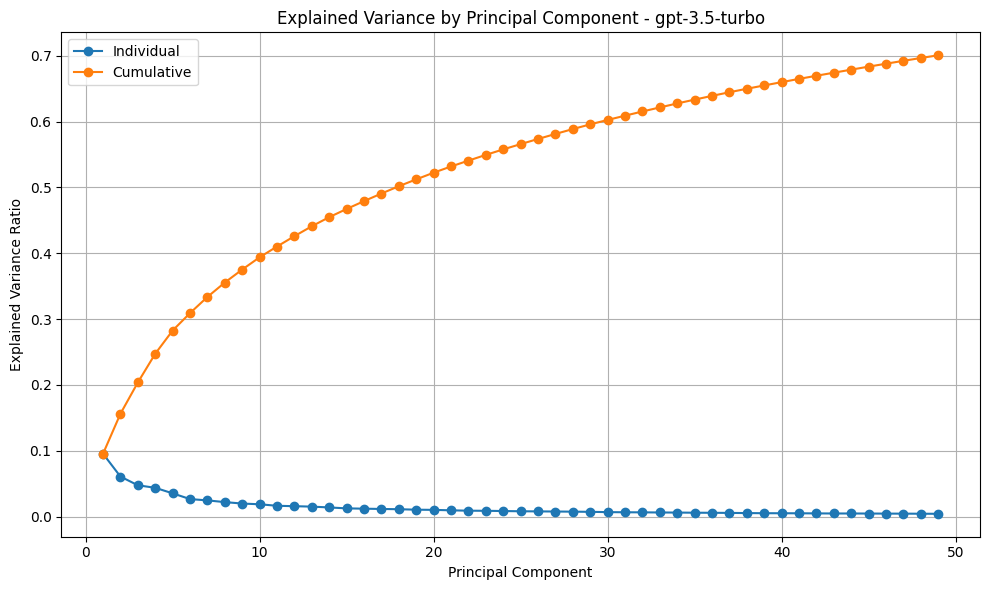

<Figure size 640x480 with 0 Axes>

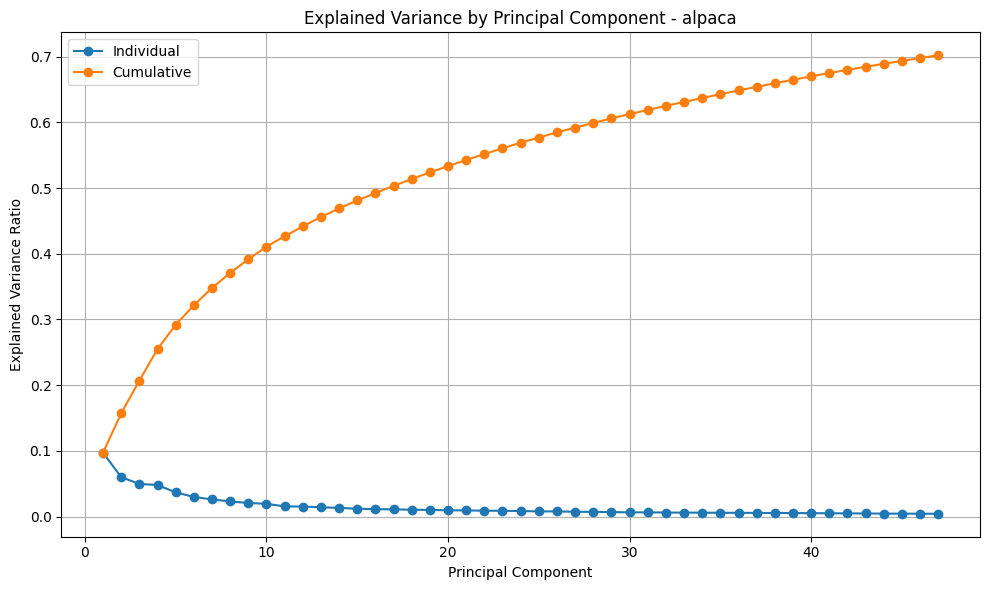

<Figure size 640x480 with 0 Axes>

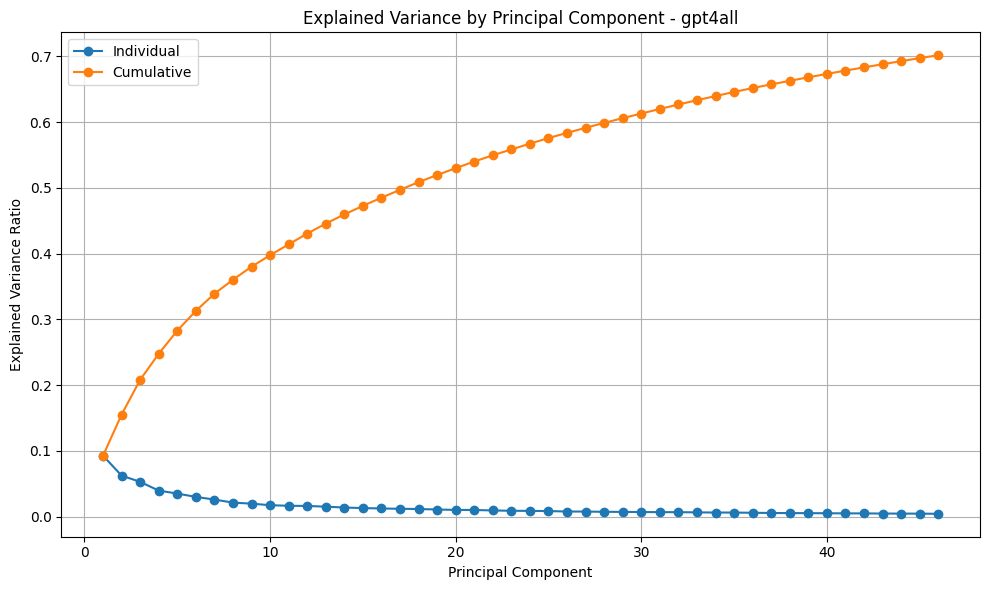

<Figure size 640x480 with 0 Axes>

In [17]:
import matplotlib.pyplot as plt

for llm, embs in kmeans_pca_data.items():

    # Simple Line Plot
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, len(embs[0])+1), embs[0], label='Individual', marker='o')
    plt.plot(range(1, len(embs[0])+1), embs[1], label='Cumulative', marker='o')
    plt.title(f'Explained Variance by Principal Component - {llm}')
    plt.xlabel('Principal Component')
    plt.ylabel('Explained Variance Ratio')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()
    plt.savefig(f'fig/{llm}_var_exp.png', dpi=300)

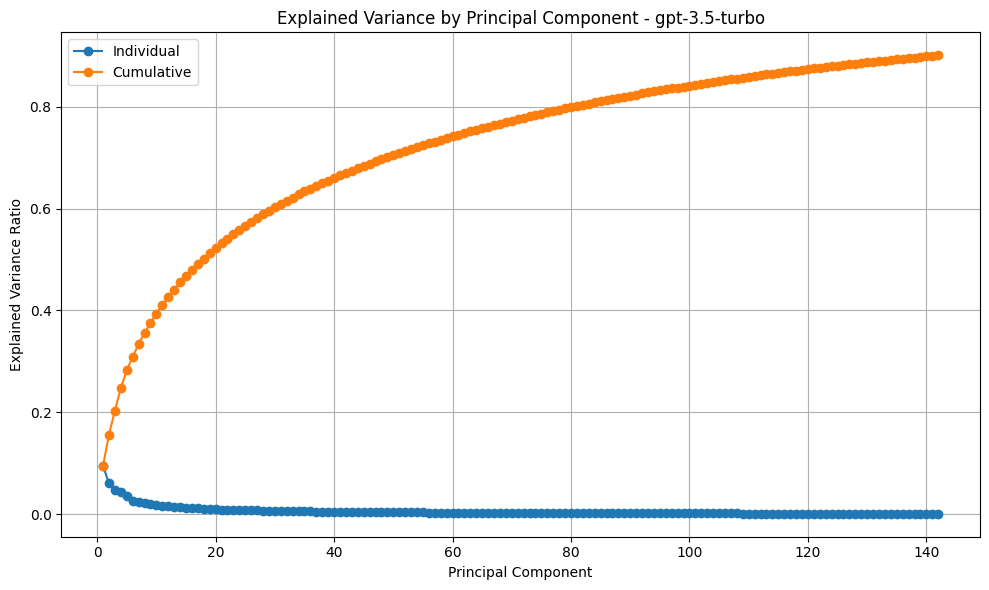

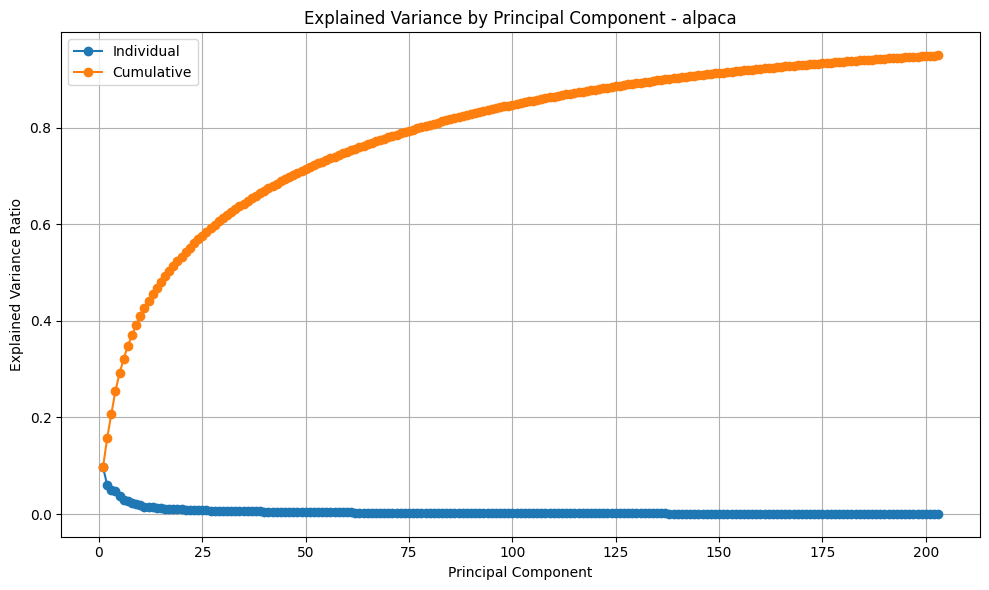

In [18]:
for llm, embs in dbscan_pca_data.items():

    # Simple Line Plot
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, len(embs[0])+1), embs[0], label='Individual', marker='o')
    plt.plot(range(1, len(embs[0])+1), embs[1], label='Cumulative', marker='o')
    plt.title(f'Explained Variance by Principal Component - {llm}')
    plt.xlabel('Principal Component')
    plt.ylabel('Explained Variance Ratio')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [19]:
df_new[['full_text', 'gpt-3.5-turbo', 'gpt-3.5-turbo_kmeans']].to_excel('xlsx/gpt-3.5-turbo_kmeans.xlsx', index=True)
df_new[['full_text', 'alpaca', 'alpaca_kmeans']].to_excel('xlsx/alpaca_kmeans.xlsx', index=True)
df_new[['full_text', 'gpt4all', 'gpt4all_kmeans']].to_excel('xlsx/gpt4all_kmeans.xlsx', index=True)

df_new[['full_text', 'gpt-3.5-turbo', 'gpt-3.5-turbo_dbscan']].to_excel('xlsx/gpt-3.5-turbo_dbscan.xlsx', index=True)
df_new[['full_text', 'alpaca', 'alpaca_dbscan']].to_excel('xlsx/alpaca_dbscan.xlsx', index=True)

In [17]:
from helpers.data_viz import plot_clusters_2D

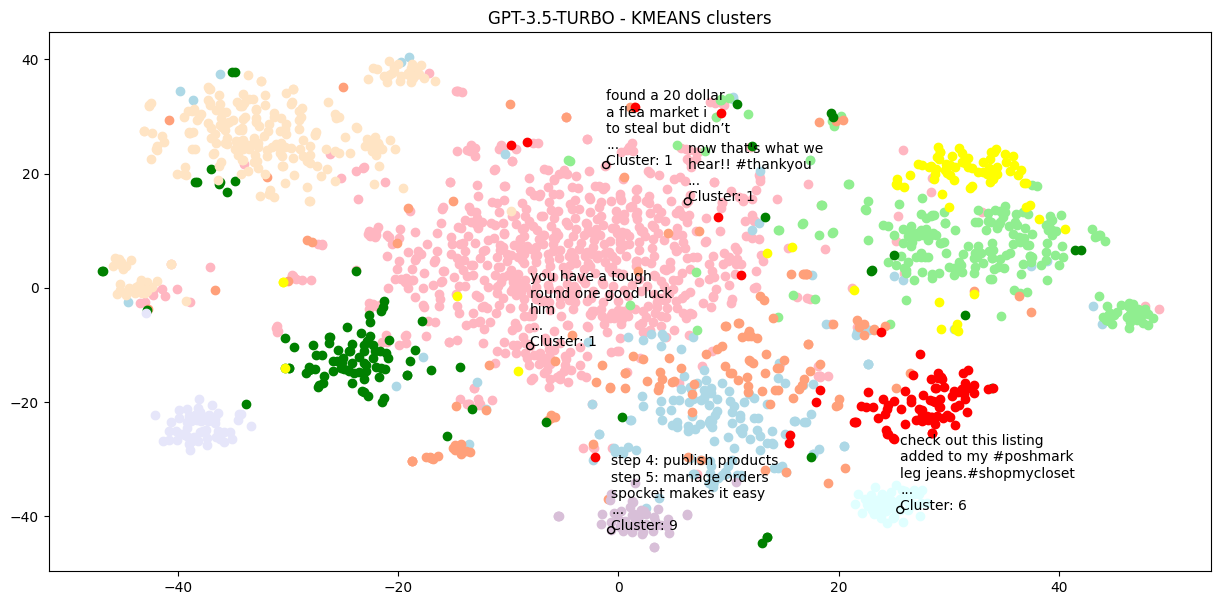

In [18]:
plot_clusters_2D(df=df_new,
                 llm='gpt-3.5-turbo',
                 cluster_algo='kmeans',
                 text_col='tweet',
                 n=6,
                 save_fig=True,
                 fig_name='comp_0-1-turbo-tweet',
                 indices=[484,
                          146,
                          91,
                          617,
                          217],
                 manual=True)

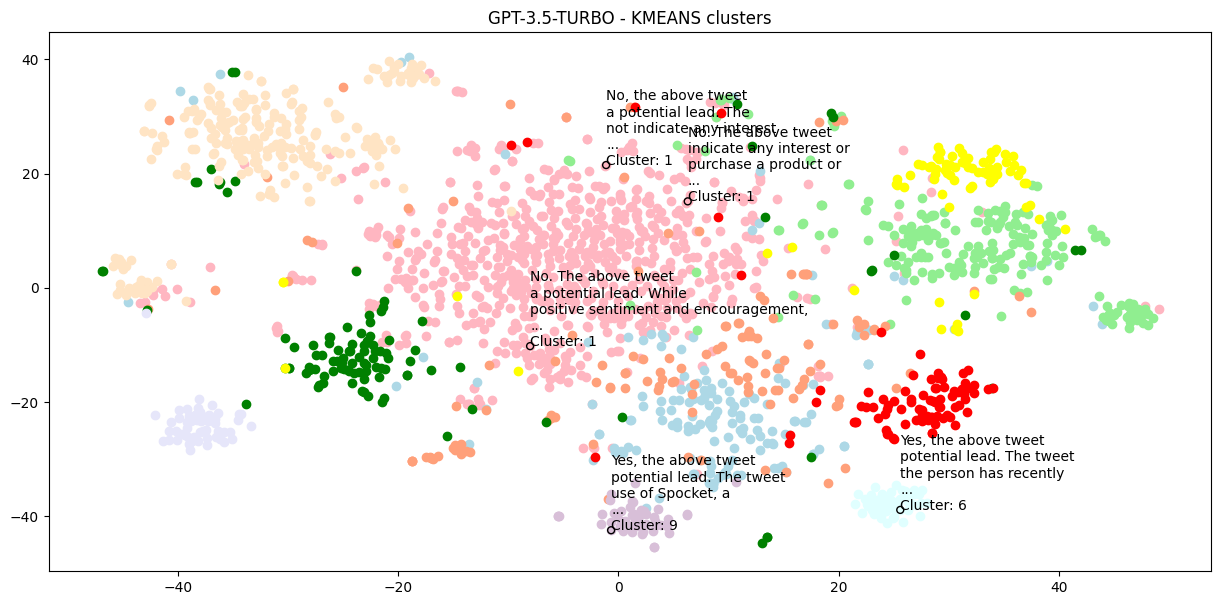

In [22]:
plot_clusters_2D(df=df_new,
                 llm='gpt-3.5-turbo',
                 cluster_algo='kmeans',
                 text_col='output',
                 n=6,
                 save_fig=True,
                 fig_name='comp_0-1-turbo-output',
                 indices=[484,
                          146,
                          91,
                          617,
                          217],
                 manual=True)